In [1]:
# https://medium.com/swlh/resnet-with-tensorflow-transfer-learning-13ff0773cf0c

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
from glob import glob

np.random.seed(42)
from sklearn.metrics import confusion_matrix

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats

In [3]:
# Load metadata
metadata_path = "../dataset/HAM10000_metadata.csv"
skin_df = pd.read_csv(metadata_path)

### Load images size

In [4]:
SIZE = 32

### Label encoding to numeric values from text

In [5]:
le = LabelEncoder()
le.fit(skin_df['dx'])

LabelEncoder()

In [6]:
skin_df['label'] = le.transform(skin_df['dx'])

### Balance Data

In [7]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=1500

df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

### Combine back to a single dataframe

In [8]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced,
                              df_6_balanced])

In [9]:
skin_df_balanced['label'].value_counts()

label
0    1500
1    1500
2    1500
3    1500
4    1500
5    1500
6    1500
Name: count, dtype: int64

#### Read images

In [10]:
# Define image folder path
image_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../dataset/', '*', '*.jpg'))}

In [11]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

#### Read all images

In [12]:
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))

#### Convert images to numpy array

In [13]:
# Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. 
Y = skin_df_balanced['label']
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

###  Model part

In [14]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
# for layer in base_model.layers:
#   layer.trainable = True

In [15]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(10500, activation='relu')(x)
predictions = layers.Dense(7, activation = 'softmax')(x)

In [16]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [19]:
history = head_model.fit(x_train, y_train, batch_size=32, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40
247/247 [==============================] - 495s 2s/step - loss: 0.6795 - accuracy: 0.7658 - val_loss: 1.5699 - val_accuracy: 0.6072
Epoch 2/40
247/247 [==============================] - 487s 2s/step - loss: 0.5904 - accuracy: 0.8014 - val_loss: 0.9534 - val_accuracy: 0.6872
Epoch 3/40
247/247 [==============================] - 472s 2s/step - loss: 0.6359 - accuracy: 0.7888 - val_loss: 5.6216 - val_accuracy: 0.3509
Epoch 4/40
247/247 [==============================] - 515s 2s/step - loss: 1.2404 - accuracy: 0.5539 - val_loss: 2.1835 - val_accuracy: 0.5314
Epoch 5/40
216/247 [=========================>....] - ETA: 1:00 - loss: 0.7109 - accuracy: 0.7486

KeyboardInterrupt: 

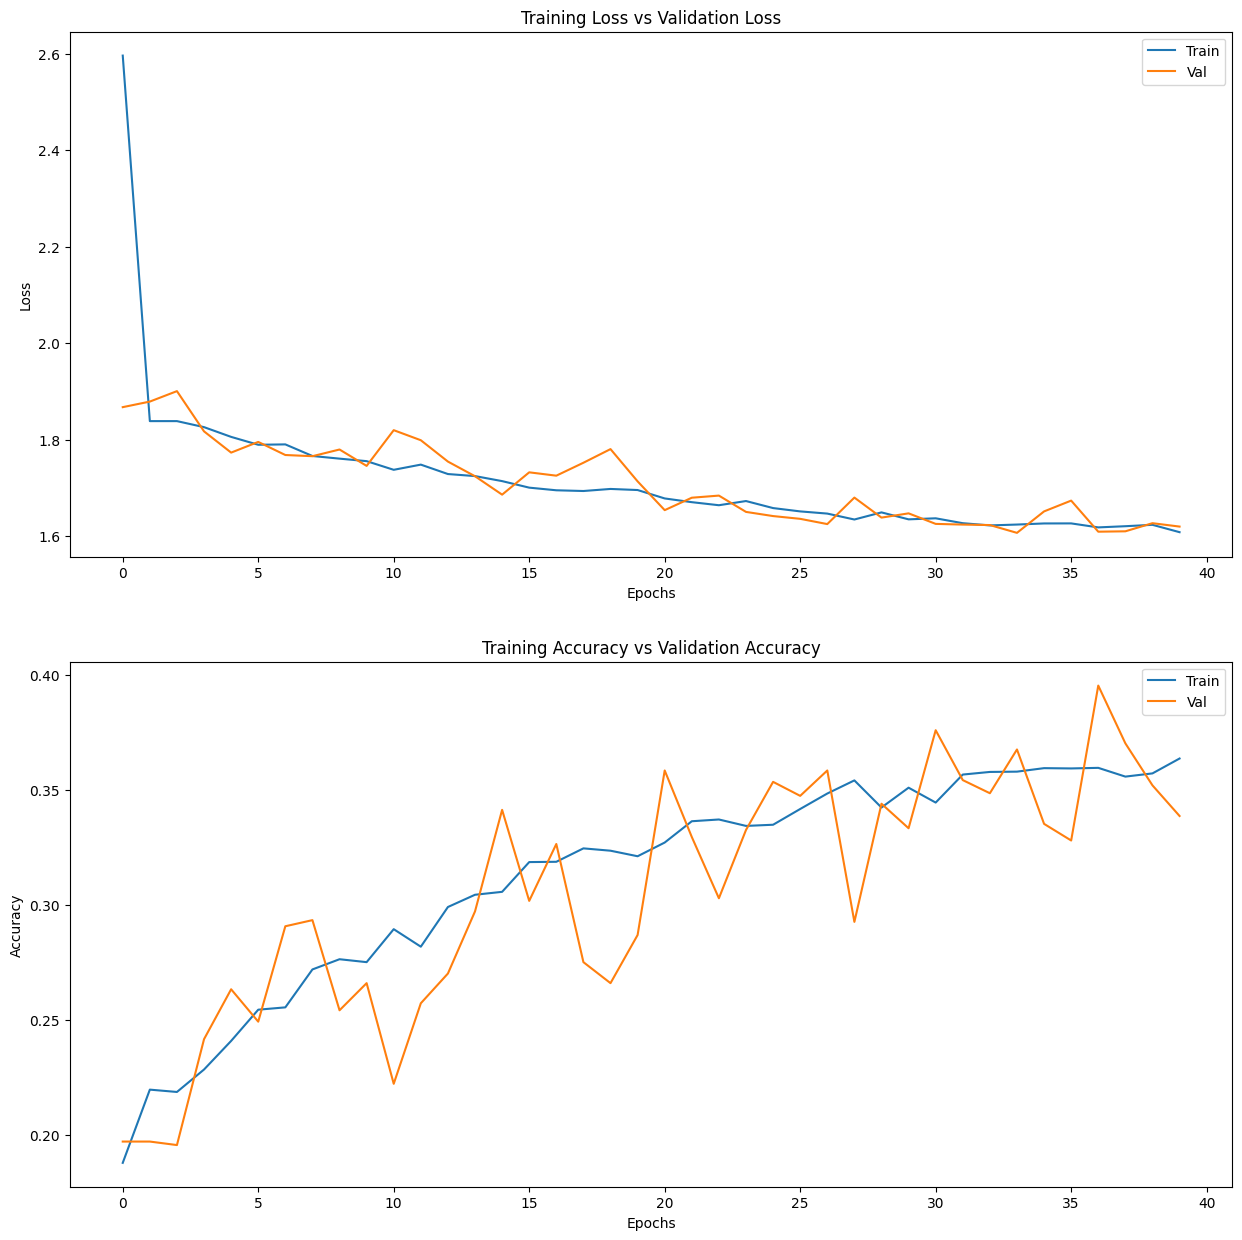

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
head_model.evaluate(x_test, y_test)

83/83 [==============================] - 9s 109ms/step - loss: 1.6195 - accuracy: 0.3387


[1.6194552183151245, 0.3386666774749756]